## LGB starter

In this notebook:
* I build simple features from book and trade datasets;
* I train a lightgbm model **with weights** with a custom metric (RMSPE) and obtain a CV score;

Credits to:
* https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data
* https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/250324

**I hope it will be useful for beginners. By creating new variables you can easily improve this model.**

In [1]:
# !pip install arch

In [2]:
from IPython.core.display import display, HTML
# from arch import arch_model
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc
from tqdm import tqdm
from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
import lightgbm as lgb

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
# from arch.__future__ import reindexing

path_root = '../data/'
path_data = '../data/'
path_submissions = '/'

target_name = 'target'
scores_folds = {}


C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
# path_data

In [4]:
# # test
# stock_id = 0 
# dataType = 'train'
# key = ['stock_id', 'time_id', 'seconds_in_bucket']

# df_book = pd.read_parquet(os.path.join(path_data, 'book_{}.parquet/stock_id={}/'.format(dataType, stock_id)))
# df_book['stock_id'] = stock_id
# cols = key + [col for col in df_book.columns if col not in key]
# df_book = df_book[cols]
# df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] +
#                                 df_book['ask_price1'] * df_book['bid_size1']) / (df_book['bid_size1'] + df_book['ask_size1'])
# df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] +
#                                 df_book['ask_price2'] * df_book['bid_size2']) / (df_book['bid_size2'] + df_book['ask_size2'])
# df_book['log_return1'] = df_book.groupby(by = ['time_id'])['wap1'].apply(log_return).fillna(0)
# df_book['log_return2'] = df_book.groupby(by = ['time_id'])['wap2'].apply(log_return).fillna(0)
# # df_book
# features_to_apply_realized_volatility = ['log_return'+str(i+1) for i in range(2)]
# stock_stat = df_book.groupby(by = ['stock_id', 'time_id'])[features_to_apply_realized_volatility]\
#                         .agg(realized_volatility).reset_index()
# stock_stat

In [5]:
# from sklearn.preprocessing import PolynomialFeatures

# stock_stat['log_return1']**1

In [6]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
# def arch_vol(ts):
# #     ts = ts
#     ts = ts.astype('double')
#     model = arch_model(ts, mean='Constant', vol='ARCH', p=1,rescale = False)
#     model_fit = model.fit(disp='off', show_warning=False)
#     # forecast the test set
#     yhat = model_fit.forecast(horizon=600)
#     return np.sqrt(yhat.variance.values[-1, :].max())  
def get_stock_stat(stock_id : int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    #Book features
    df_book = pd.read_parquet(os.path.join(path_data, 'book_{}.parquet/stock_id={}/'.format(dataType, stock_id)))
    df_book['stock_id'] = stock_id
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] +
                                    df_book['ask_price1'] * df_book['bid_size1']) / (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] +
                                    df_book['ask_price2'] * df_book['bid_size2']) / (df_book['bid_size2'] + df_book['ask_size2'])
    df_book['log_return1'] = df_book.groupby(by = ['time_id'])['wap1'].apply(log_return).fillna(0)
    df_book['log_return2'] = df_book.groupby(by = ['time_id'])['wap2'].apply(log_return).fillna(0)
    #         sum_df_1 = df_book[df_book.seconds_in_bucket>= window].groupby("time_id")["log_return"].sum().reset_index()
#         sum_df["volatility_"+str(window)] = (sum_df_1["diff_log_wap2"])**0.5
#         sum_df['len_'+str(window)] = df[df.seconds_in_bucket>= window].groupby("time_id").size().reset_index(drop = True)
# #     sum_df = df.groupby("time_id")["diff_log_wap2"].sum().reset_index()
# #     sum_df["volatility"] = (sum_df["diff_log_wap2"])**0.5
#     sum_df["len_300"] = sum_df["len_300"]/(sum_df["len_0"]*100)
#     sum_df["len_540"] = sum_df["len_540"]/(sum_df["len_0"]*100)
#     sum_df["len_0"] = sum_df["len_0"]/(600*100)
    features_to_apply_realized_volatility = ['log_return'+str(i+1) for i in range(2)]
#     arch_volat  = df_book.groupby(by = ['stock_id', 'time_id'])[features_to_apply_realized_volatility]\
#                         .agg(arch_vol).reset_index().rename(columns={'log_return1': 'arch_vol_1','log_return2' : 'arch_vol_2'})
#     arch_vol = arch_vol.rename()
    stock_stat = df_book.groupby(by = ['stock_id', 'time_id'])[features_to_apply_realized_volatility]\
                        .agg(realized_volatility).reset_index()
    df_book['wap_balance'] = abs(df_book['wap1'] - df_book['wap2'])
    df_book['price_spread'] = (df_book['ask_price1'] - df_book['bid_price1']) / ((df_book['ask_price1'] + df_book['bid_price1'])/2)
    df_book['bid_spread'] = df_book['bid_price1'] - df_book['bid_price2']
    df_book['ask_spread'] = df_book['ask_price1'] - df_book['ask_price2']
    df_book['total_volume'] = (df_book['ask_size1'] + df_book['ask_size2']) + (df_book['bid_size1'] + df_book['bid_size2'])
    df_book['volume_imbalance'] = abs((df_book['ask_size1'] + df_book['ask_size2']) - (df_book['bid_size1'] + df_book['bid_size2']))
    create_feature_dict = {
        #'log_return':[realized_volatility],
        #'log_return2':[realized_volatility],
        'wap_balance':[np.mean],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap1':[np.mean],
        'wap2':[np.mean],
        'wap_balance':[np.std],
        'price_spread':[np.std],
        'bid_spread':[np.std],
        'ask_spread':[np.std],
        'volume_imbalance':[np.std],
        'total_volume':[np.std],
        'wap1':[np.std],
        'wap2':[np.std],
            }

    #####groupby / all seconds
    df_feature = pd.DataFrame(df_book.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
    df_feature.columns = ['_'.join(col) for col in df_feature.columns] #time_id is changed to time_id_
        
    ######groupby / last XX seconds
    last_seconds = [300, 60,120]
    
    for second in last_seconds:
        second = 600 - second 
    
        df_feature_sec = pd.DataFrame(df_book.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()

        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns] #time_id is changed to time_id_
     
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))

        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    #create row_id
#     stock_id = stock_id
#     df_feature['row_id'] = df_feature['time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.rename(columns = {'time_id_' : 'time_id'})
    stock_stat = stock_stat.merge(df_feature, on='time_id', how='left').fillna(0)

    for window in [300,540]:
        a = df_book[df_book.seconds_in_bucket>= window].groupby("time_id")["log_return1"].agg(realized_volatility).reset_index().rename(columns={'log_return1': 'vol_1_'+str(window)})
        b = df_book[df_book.seconds_in_bucket>= window].groupby("time_id")["log_return2"].agg(realized_volatility).reset_index().rename(columns={'log_return2': 'vol_2_'+str(window)})

        stock_stat = stock_stat.merge(a, on='time_id', how='left').fillna(0)
        stock_stat = stock_stat.merge(b, on='time_id', how='left').fillna(0)
        stock_stat['len_'+str(window)] = df_book[df_book.seconds_in_bucket>= window].groupby("time_id").size().reset_index(drop = True)
    window = 0
    stock_stat['len_'+str(window)] = df_book[df_book.seconds_in_bucket>= window].groupby("time_id").size().reset_index(drop = True)
#     stock_stat[log]
    
    
        #Trade features
    trade_stat =  pd.read_parquet(os.path.join(path_data,'trade_{}.parquet/stock_id={}'.format(dataType, stock_id)))
    trade_stat = trade_stat.sort_values(by=['time_id', 'seconds_in_bucket']).reset_index(drop=True)
    trade_stat['stock_id'] = stock_id
    cols = key + [col for col in trade_stat.columns if col not in key]
    trade_stat = trade_stat[cols]
    agg_df = trade_stat.groupby(['stock_id', 'time_id']).agg(mean_sec_in_bucket = ('seconds_in_bucket', 'mean'), 
                                                     mean_price = ('price', 'mean'),
                                                     mean_size = ('size', 'mean'),
                                                     mean_order = ('order_count', 'mean'),
                                                     max_sec_in_bucket = ('seconds_in_bucket', 'max'), 
                                                     max_price = ('price', 'max'),
                                                     max_size = ('size', 'max'),
                                                     max_order = ('order_count', 'max'),
                                                     min_sec_in_bucket = ('seconds_in_bucket', 'min'), 
                                                     min_price = ('price', 'min'),
                                                     min_size = ('size', 'min'),
                                                     sum_size = ('size', 'sum'),
                                                     min_order = ('order_count', 'min'),
                                                     median_sec_in_bucket = ('seconds_in_bucket', 'median'), 
                                                     median_price = ('price', 'median'),
                                                     median_size = ('size', 'median'),
                                                     median_order = ('order_count', 'median')
                                                    ).reset_index()
#     arch_preds = stock_stat.groupby(['stock_id', 'time_id'])
    stock_stat = stock_stat.merge(agg_df, on=['stock_id', 'time_id'], how='left').fillna(0)
    trade_stat['trade_log_return1'] = trade_stat.groupby(by = ['time_id'])['price'].apply(log_return).fillna(0)
    trade_stat = trade_stat.groupby(by = ['stock_id', 'time_id'])[['trade_log_return1']]\
                           .agg(realized_volatility).reset_index()
    #Joining book and trade features
    stock_stat = stock_stat.merge(trade_stat, on=['stock_id', 'time_id'], how='left').fillna(-999)
    for i in [2,3]:
        stock_stat['log_return1_'+str(i)] = stock_stat['log_return1']**i
        stock_stat['log_return2_'+str(i)] = stock_stat['log_return2']**i
        stock_stat['trade_log_return1_'+str(i)] = stock_stat['trade_log_return1']**i
    return stock_stat

def get_dataSet(stock_ids : list, dataType = 'train'):

    stock_stat = Parallel(n_jobs=-1)(
        delayed(get_stock_stat)(stock_id, dataType) 
        for stock_id in tqdm(stock_ids)
    )
    
    stock_stat_df = pd.concat(stock_stat, ignore_index = True)

    return stock_stat_df

def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

# params_lgbm = {
#         'task': 'train',
#         'boosting_type': 'gbdt',
#         'learning_rate': 0.01,
#         'objective': 'regression',
#         'metric': 'None',
#         'max_depth': -1,
#         'n_jobs': -1,
#         'feature_fraction': 0.7,
#         'bagging_fraction': 0.7,
#         'lambda_l2': 1,
#         'verbose': -1
#         #'bagging_freq': 5
# }

In [7]:
# get_stock_stat(0, dataType = 'train')


In [8]:
# # df_book
# # get_stock_stat(0, dataType = 'train')

# def calc_wap(df):
#     wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
#     return wap
# def calc_wap2(df):
#     wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
#     return wap
# def log_return(list_stock_prices):
#     return np.log(list_stock_prices).diff() 
# def realized_volatility(series):
#     return np.sqrt(np.sum(series**2))
# def count_unique(series):
#     return len(np.unique(series))
# def preprocessor_book(stock_id : int, dataType = 'train'):
#     df = pd.read_parquet(os.path.join(path_data, 'book_{}.parquet/stock_id={}/'.format(dataType, stock_id)))
#     #calculate return etc
#     df['wap'] = calc_wap(df)
#     df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
    
#     df['wap2'] = calc_wap2(df)
#     df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    
#     df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
#     df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
#     df['bid_spread'] = df['bid_price1'] - df['bid_price2']
#     df['ask_spread'] = df['ask_price1'] - df['ask_price2']
#     df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
#     df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

#     #dict for aggregate
#     create_feature_dict = {
#         'log_return':[realized_volatility],
#         'log_return2':[realized_volatility],
#         'wap_balance':[np.mean],
#         'price_spread':[np.mean],
#         'bid_spread':[np.mean],
#         'ask_spread':[np.mean],
#         'volume_imbalance':[np.mean],
#         'total_volume':[np.mean],
#         'wap':[np.mean],
#             }

#     #####groupby / all seconds
#     df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
#     df_feature.columns = ['_'.join(col) for col in df_feature.columns] #time_id is changed to time_id_
        
#     ######groupby / last XX seconds
#     last_seconds = [300]
    
#     for second in last_seconds:
#         second = 600 - second 
    
#         df_feature_sec = pd.DataFrame(df.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()

#         df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns] #time_id is changed to time_id_
     
#         df_feature_sec = df_feature_sec.add_suffix('_' + str(second))

#         df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
#         df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
#     #create row_id
# #     stock_id = stock_id
#     df_feature['row_id'] = df_feature['time_id_'].apply(lambda x:f'{stock_id}-{x}')
#     df_feature = df_feature.drop(['time_id_'],axis=1)
    
#     return df_feature


In [9]:
# file_path = data_dir + "book_train.parquet/stock_id=0"
# preprocessor_book(0,'train')

## Train and test datasets

In [10]:
train = pd.read_csv(os.path.join(path_data, 'train.csv'))
%time train_stock_stat_df = get_dataSet(stock_ids = train['stock_id'].unique(), dataType = 'train')
train = pd.merge(train, train_stock_stat_df, on = ['stock_id', 'time_id'], how = 'left')
print('Train shape: {}'.format(train.shape))
display(train.head(2))

test = pd.read_csv(os.path.join(path_data, 'test.csv'))
test_stock_stat_df = get_dataSet(stock_ids = test['stock_id'].unique(), dataType = 'test')
test = pd.merge(test, test_stock_stat_df, on = ['stock_id', 'time_id'], how = 'left').fillna(0)
print('Test shape: {}'.format(test.shape))
display(test.head(2))

 71%|█████████████████████████████████████████████████████████▊                       | 80/112 [04:22<01:53,  3.54s/it]C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [06:13<00:00,  3.34s/it]


Wall time: 7min 1s
Train shape: (428932, 68)


,stock_id,time_id,target,log_return1,log_return2,wap_balance_std,price_spread_std,bid_spread_std,ask_spread_std,volume_imbalance_std,...,median_price,median_size,median_order,trade_log_return1,log_return1_2,log_return2_2,trade_log_return1_2,log_return1_3,log_return2_3,trade_log_return1_3
0,0,5,0.004136,0.004499,0.006999,0.000295,0.000211,0.000162,0.000126,107.260583,...,1.003879,19.5,2.0,0.002006,0.000020,0.000049,4.023593e-06,9.108666e-08,3.427834e-07,8.070883e-09
1,0,11,0.001445,0.001204,0.002476,0.000155,0.000157,0.000148,0.000065,102.139758,...,1.000192,3.0,1.0,0.000901,0.000001,0.000006,8.114041e-07,1.747070e-09,1.518601e-08,7.308964e-10


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Test shape: (3, 68)


,stock_id,time_id,row_id,log_return1,log_return2,wap_balance_std,price_spread_std,bid_spread_std,ask_spread_std,volume_imbalance_std,...,median_price,median_size,median_order,trade_log_return1,log_return1_2,log_return2_2,trade_log_return1_2,log_return1_3,log_return2_3,trade_log_return1_3
0,0,4,0-4,0.000294,0.000252,0.000022,0.000028,0.0,0.000113,165.711597,...,1.000059,100.0,3.0,0.000295,8.655287e-08,6.350246e-08,8.711406e-08,2.546374e-11,1.600242e-11,2.571179e-11
1,0,32,0-32,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [11]:
# test.merge(enc2, on = 'stock_id')
# train[train.columns[2:]].describe()
# train

In [12]:
# train.to_csv('cus_train.csv',index = False)
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=4, random_state=0,shuffle = True)

# skf.split(train, train['stock_id'])
# kf = model_selection.KFold(n_splits=n_folds, stratify = train.time_id, random_state=2016)
# enc = train.groupby('stock_id')['target'].agg(np.mean).reset_index().rename(columns = {'target' : 'mean_tar'})
# enc2 = train.groupby('stock_id')['target'].agg(np.std).reset_index().rename(columns = {'target' : 'std_tar'})

# train = enc.merge(train, on = 'stock_id').merge(enc2, on = 'stock_id')
# test = test.merge(enc,on= 'stock_id').merge(enc2 , on = 'stock_id')

In [13]:
# train.columns.tolist()

In [14]:
# test
df_train = train.copy()
df_test = test.copy()

In [15]:
# df_test

In [16]:
# encoding trainging 
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=19901028, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0  
from sklearn.model_selection import KFold
#stock_id target encoding
# df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
# df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

#training
tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)
for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp

In [17]:
# train.time_id
train['stock_id_target_enc'] = df_train['stock_id_target_enc']
test['stock_id_target_enc'] = df_test['stock_id_target_enc']

In [22]:
# train[train.time_id == 5]
train['stock_id'] = train['stock_id'].astype('int')
test['stock_id'] = test['stock_id'].astype('int')

# train2 = train.copy()

In [23]:

# train = train2[train.stock_id.isin(list(set(train.stock_id.unique().tolist())-set([31])))]

## Training model and making predictions

We consider 54 features


C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's rmse: 0.000591259	valid_0's RMSPE: 0.27356
[500]	valid_0's rmse: 0.000557265	valid_0's RMSPE: 0.25784
[750]	valid_0's rmse: 0.000549761	valid_0's RMSPE: 0.25436
[1000]	valid_0's rmse: 0.000545442	valid_0's RMSPE: 0.25236
[1250]	valid_0's rmse: 0.000543031	valid_0's RMSPE: 0.25125
[1500]	valid_0's rmse: 0.000541571	valid_0's RMSPE: 0.25057
[1750]	valid_0's rmse: 0.0005405	valid_0's RMSPE: 0.25008
[2000]	valid_0's rmse: 0.000540149	valid_0's RMSPE: 0.24992
[2250]	valid_0's rmse: 0.000539719	valid_0's RMSPE: 0.24972
[2500]	valid_0's rmse: 0.000539287	valid_0's RMSPE: 0.24952
[2750]	valid_0's rmse: 0.000538991	valid_0's RMSPE: 0.24938
[3000]	valid_0's rmse: 0.000538887	valid_0's RMSPE: 0.24933
[3250]	valid_0's rmse: 0.000539308	valid_0's RMSPE: 0.24953
Early stopping, best iteration is:
[2958]	valid_0's rmse: 0.000538849	valid_0's RMSPE: 0.24931
Fold 1 lgb2: 0.24931
Training until validation scores don't improve 

,row_id,target
0,0-4,0.001282
1,0-32,0.001585


Text(0, 0.5, 'Feature')

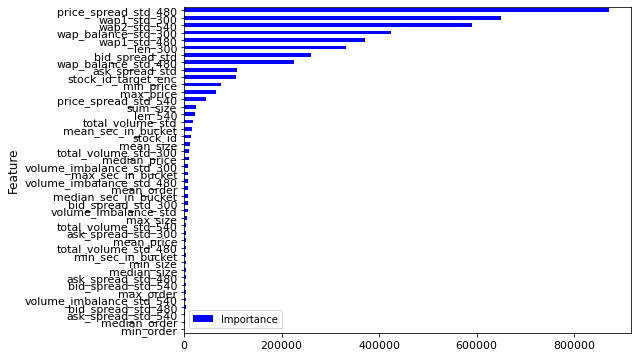

In [42]:
cats = []
model_name = 'lgb2'
pred_name = 'pred_{}'.format(model_name)
# features_to_consider = ['stock_id', 'log_return1', 'log_return2', 'trade_log_return1']
features_to_consider = ['stock_id',
#  'log_return1',
#  'log_return2',
 'wap_balance_std',
 'price_spread_std',
 'bid_spread_std',
 'ask_spread_std',
 'volume_imbalance_std',
 'total_volume_std',
 'wap1_std',
 'wap2_std',
 'wap_balance_std_300',
 'price_spread_std_300',
 'bid_spread_std_300',
 'ask_spread_std_300',
 'volume_imbalance_std_300',
 'total_volume_std_300',
 'wap1_std_300',
 'wap2_std_300',
 'wap_balance_std_540',
 'price_spread_std_540',
 'bid_spread_std_540',
 'ask_spread_std_540',
 'volume_imbalance_std_540',
 'total_volume_std_540',
 'wap1_std_540',
 'wap2_std_540',
 'wap_balance_std_480',
 'price_spread_std_480',
 'bid_spread_std_480',
 'ask_spread_std_480',
 'volume_imbalance_std_480',
 'total_volume_std_480',
 'wap1_std_480',
 'wap2_std_480',
#  'vol_1_300',
#  'vol_2_300',
 'len_300',
#  'vol_1_540',
#  'vol_2_540',
 'len_540',
 'len_0',
 'mean_sec_in_bucket',
 'mean_price',
 'mean_size',
 'mean_order',
 'max_sec_in_bucket',
 'max_price',
 'max_size',
 'max_order',
 'min_sec_in_bucket',
 'min_price',
 'min_size',
 'sum_size',
 'min_order',
 'median_sec_in_bucket',
 'median_price',
 'median_size',
 'median_order',
#  'trade_log_return1',
#  'log_return1_2',
#  'log_return2_2',
#  'trade_log_return1_2',
#  'log_return1_3',
#  'log_return2_3',
#  'trade_log_return1_3',
 'stock_id_target_enc']
#                        ]
print('We consider {} features'.format(len(features_to_consider)))

train[pred_name] = 0
test['target'] = 0

# n_folds_outer = 4
n_folds = 5
n_rounds = 10000
# #StratifiedKFold(n_splits=5, random_state=0)
# # kf = model_selection.KFold(n_splits=n_folds, stratify = train.time_id, random_state=2016)
# # kf = model_selection.KFold(n_splits=n_folds,shuffle = True,random_state=2016)
# # train.to_csv('cus_train.csv',index = False)
# # from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold , KFold
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2016)
features_to_consider = list(set(features_to_consider)-set(a)) 
time_ids = train.time_id.unique().tolist()
for dev_index, val_index in kf.split(range(len(time_ids ))):
    times_dev = [time_ids [i] for i in dev_index]; 
    times_val = [time_ids [i] for i in val_index];
# skf0 = StratifiedKFold(n_splits=n_folds_outer, random_state=2016,shuffle = True)
# skf = StratifiedKFold(n_splits=n_folds, random_state=45478,shuffle = True)
params_lgbm = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': -1,
        'n_jobs': -1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
#         'lambda_l2': 1,
        'lambda_l1' : 1,
        'verbose': -1
        #'bagging_freq': 5
}

# # train_X, val_X, train_y , val_y = train_test_split(train_df, train_df[cols_target], test_size=0.1, random_state = 0,stratify = train_df['Label'])
# scores_folds[model_name] = []
# score_outer = [0]*n_folds_outer
# counter = 1
# counter_outer = 0
# # for dev_index, val_index in kf.split(range(len(train))):
# # outer loop
# for dev_index0, val_index0 in skf0.split(train, train['stock_id']):
#     print('CV_outer {}/{}'.format(counter, n_folds_outer))
#     X_train_X = train.loc[dev_index0, features_to_consider+['time_id']]
#     y_train_X = train.loc[dev_index0, target_name]
#     X_val_X = train.loc[val_index0, features_to_consider+['time_id']]
#     y_val_X = train.loc[val_index0, target_name]
#     for dev_index, val_index in skf.split(X_train_X, X_train_X['time_id']):
#         print('CV {}/{}'.format(counter, n_folds_inner))
#         X_train = train.loc[dev_index, features_to_consider]
#         y_train = train.loc[dev_index, target_name].values
#         X_val = train.loc[val_index, features_to_consider]
#         y_val = train.loc[val_index, target_name].values

#         #############################################################################################
#         #LGB
#         #############################################################################################
#         train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cats, weight=1/np.power(y_train,2))
#         val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cats, weight=1/np.power(y_val,2))

#         model = lgb.train(params_lgbm, 
#                           train_data, 
#                           n_rounds, 
#                           valid_sets=val_data, 
#                           feval=feval_RMSPE,
#                           verbose_eval= 250,
#                           early_stopping_rounds=500
#                          )
#         preds = model.predict(train.loc[val_index, features_to_consider])
#         score = round(rmspe(y_true = y_val, y_pred = preds),5)
#         train.loc[val_index, pred_name] = train.loc[val_index, pred_name] + preds*(1/score)
#         print('Fold {} {}: {}'.format(counter, model_name, score))
#         scores_folds[model_name].append(score)
#         counter += 1
#         score_outer[counter_outer] += 1/score
#         test[target_name] += (model.predict(test[features_to_consider]).clip(0,1e10))*(1/score)
#     test[target_name] = test[target_name] 
#     counter_outer+=1
# del train_data, val_data
# test[target_name] = test[target_name]/(n_folds_outer)

# score = round(rmspe(y_true = train[target_name].values, y_pred = train[pred_name].values/n_folds),5)
# print('RMSPE {}: {} - Folds: {}'.format(model_name, score, scores_folds[model_name]))

# display(test[['row_id', target_name]].head(2))
# test[['row_id', target_name]].to_csv('submission.csv',index = False)

# importances = pd.DataFrame({'Feature': model.feature_name(), 
#                             'Importance': model.feature_importance(importance_type='gain')})
# importances.sort_values(by = 'Importance', inplace=True)
# importances2 = importances.nlargest(50,'Importance', keep='first').sort_values(by='Importance', ascending=True)
# importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (8,6), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)

scores_folds[model_name] = []
counter = 1
# for dev_index, val_index in kf.split(range(len(train))):
# for dev_index, val_index in skf.split(train, train['stock_id']):
#     print('CV {}/{}'.format(counter, n_folds))
#     X_train = train.loc[dev_index, features_to_consider]
#     y_train = train.loc[dev_index, target_name].values
#     X_val = train.loc[val_index, features_to_consider]
#     y_val = train.loc[val_index, target_name].values
from sklearn.model_selection import StratifiedKFold , KFold
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2016)

time_ids = train.time_id.unique().tolist()
for dev_index, val_index in kf.split(range(len(time_ids ))):
    times_dev = [time_ids [i] for i in dev_index]; 
    times_val = [time_ids [i] for i in val_index];
    X_train = train.loc[train.time_id.isin(times_dev), features_to_consider]
    y_train = train.loc[train.time_id.isin(times_dev), target_name].values
    X_val = train.loc[train.time_id.isin(times_val), features_to_consider]
    y_val = train.loc[train.time_id.isin(times_val), target_name].values
    #############################################################################################
    #LGB
    #############################################################################################
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cats, weight=1/np.power(y_train,2))
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cats, weight=1/np.power(y_val,2))
    
    model = lgb.train(params_lgbm, 
                      train_data, 
                      n_rounds, 
                      valid_sets=val_data, 
                      feval=feval_RMSPE,
                      verbose_eval= 250,
                      early_stopping_rounds=500
                     )
    preds = model.predict(X_val)
    train.loc[train.time_id.isin(times_val), pred_name] = preds
    score = round(rmspe(y_true = y_val, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    counter += 1
    test[target_name] += model.predict(test[features_to_consider]).clip(0,1e10)
del train_data, val_data
test[target_name] = test[target_name]/n_folds

score = round(rmspe(y_true = train[target_name].values, y_pred = train[pred_name].values),5)
print('RMSPE {}: {} - Folds: {}'.format(model_name, score, scores_folds[model_name]))

display(test[['row_id', target_name]].head(2))
test[['row_id', target_name]].to_csv('submission.csv',index = False)

importances = pd.DataFrame({'Feature': model.feature_name(), 
                            'Importance': model.feature_importance(importance_type='gain')})
importances.sort_values(by = 'Importance', inplace=True)
importances2 = importances.nlargest(50,'Importance', keep='first').sort_values(by='Importance', ascending=True)
importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (8,6), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)

In [21]:
# from sklearn.cluster import AgglomerativeClustering
# clustering = AgglomerativeClustering().fit(train['target'].values.reshape(-1, 1))
# clustering
# l = [0]*4
# l[0]
# l
# clustering.labels_
# sum(scores_folds[model_name])
# round(rmspe(y_true = train[target_name].values, y_pred = train[pred_name].values/n_folds),15)

# a= abs(train.corr()['target']).sort_values(ascending = False)

In [22]:
# a[a>0.5]
# # gc
# train.to_csv('custom_train.csv')
# import pandas as pd 
# import numpy as np
# # train
# train = pd.read_csv('cus_train.csv')

# round(rmspe(y_true = train[target_name].values, y_pred = train[pred_name].values  ),15)
# target_name

0.223621827708218

In [23]:
# from sklearn.model_selection import StratifiedKFold , KFold
# kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2016)

# time_ids = train.time_id.unique().tolist()
# for dev_index, val_index in kf.split(range(len(time_ids ))):
#     times_dev = [time_ids [i] for i in dev_index]; 
#     times_val = [time_ids [i] for i in val_index];

In [24]:
# len(times_val)
# train.loc[train.time_id.isin(times_val)]
import seaborn as sns 
# sns.distplot(np.log(train.loc[train.stock_id == 0].target))

In [25]:
s = (np.log(train.loc[train.stock_id == 0].target)).std()
m = (np.log(train.loc[train.stock_id == 0].target)).mean()
np.exp(m+(s**2)/2) == train.loc[train.stock_id == 0].target.mean()

False

In [26]:
# np.exp(m+(s)/2)
train.loc[train.stock_id == 0].target.mean()

0.004028478078328982

In [19]:
train.to_csv('train_cust_starter.csv',index = False)

In [37]:
# train
a = importances2[['Importance', 'Feature']].sort_values(by  = 'Importance',ascending = False)['Feature'][:10].tolist()

In [41]:
train[a+['target']].corr()['target']

price_spread_std        0.725629
price_spread_std_300    0.752314
wap2_std_300            0.733705
wap2_std_480            0.740994
len_0                  -0.054558
wap1_std_540            0.700237
wap2_std                0.715277
wap1_std                0.698705
wap_balance_std         0.738948
wap_balance_std_540     0.720341
target                  1.000000
Name: target, dtype: float64